In [274]:
import itertools

import tqdm
from IPython.utils import io

In [2]:
input_file = "17_input.txt"

In [3]:
with open(input_file) as f:
    lr = f.readline().rstrip()

In [377]:
class Rock:
    def __init__(self, tower, x, y, moving=True):
        self.tower = tower
        self.x = x
        self.y = y
        self.is_moving = moving
    
    def move(self, wind_dir):
        if wind_dir == ">":
            self.move_right()
        elif wind_dir == "<":
            self.move_left()
        else:
            raise ValueError("Jet direction must be < or >")
    
    
    def move_right(self):
        # in general this is redundant - could specify in each concrete class
        if self.x + self.w < self.tower.w: # not against wall
            clashes = sum(self.tower.grid[y][x + 1] for x, y in self.pixels())
            if clashes == 0:
                self.x += 1
#     def move_right(self):
#         if self.x + self.w < self.tower.w and all(self.tower.grid[y][x]==0 for x, y in self.exposed_right()):
#             self.x += 1
            
#     def move_left(self):
#         if self.x > 0 and all(self.tower.grid[y][x]==0 for x, y in self.exposed_left()):
#             self.x -= 1
    
    
    def move_left(self):
        if self.x > 0:
            clashes = sum(self.tower.grid[y][x - 1] for x, y in self.pixels())
            if clashes == 0:
                self.x -= 1
    
    
    # def down(self):
    #     if self.y > 0 and all(self.tower.grid[y][x]==0 for x, y in self.exposed_down()):
    #         self.y -= 1
    #     else:
    #         self.is_moving = False
    
    def down(self):
        if self.y > 0 and sum(self.tower.grid[y - 1][x] for x, y in self.pixels()) == 0:
            self.y -= 1
        else:
            self.is_moving = False
    
    
    def settle(self):
        for x, y in self.pixels():
            self.tower.grid[y][x] = 1
            self.tower.col_h[x] = max(self.tower.col_h[x], y + 1)
                


class Horiz(Rock):
    rtype = "horiz"
    w = 4
    h = 1
    
    def pixels(self):
        return [[self.x + k, self.y] for k in range(self.w)]
    
    
    def exposed_left(self):
        return [[self.x - 1, self.y]]
    
    def exposed_right(self):
        return [[self.x + self.w, self.y]]
    
    def exposed_down(self):
        return [[self.x + k, self.y - 1] for k in range(self.w)]
    
    
    def move_right(self):
        end = self.x + self.w
        if end < self.tower.w and self.tower.grid[self.y][end] == 0:
            self.x += 1
    
    
    def move_left(self):
        if self.x > 0 and self.tower.grid[self.y][self.x - 1] == 0:
            self.x -= 1
    
    def down(self):
        if (self.y > 0
            and self.tower.grid[self.y-1][self.x] == 0
            and self.tower.grid[self.y-1][self.x+1] == 0
            and self.tower.grid[self.y-1][self.x+2] == 0
            and self.tower.grid[self.y-1][self.x+3] == 0
           ):
            self.y -= 1
        else:
            self.is_moving = False


class Plus(Rock):
    rtype = "plus"
    w = 3
    h = 3
    
    def pixels(self):
        bottom = [[self.x + 1, self.y]]
        center = [[self.x + k, self.y+1] for k in range(3)]
        top = [[self.x + 1, self.y + 2]]
        return bottom + center + top
    
    
    def exposed_left(self):
        return [[self.x - 1, self.y + 1], [self.x, self.y], [self.x, self.y + 2]]
    
    def exposed_right(self):
        return [[self.x + self.w, self.y + 1], [self.x + 2, self.y], [self.x + 2, self.y + 2]]
    
    def exposed_down(self):
        return [[self.x, self.y], [self.x + 1, self.y - 1], [self.x + 2, self.y]]
    
    
    def move_left(self):
        if (self.x > 0
            and self.tower.grid[self.y][self.x] == 0
            and self.tower.grid[self.y + 1][self.x - 1] == 0
            and self.tower.grid[self.y + 2][self.x] == 0
        ):
            self.x -= 1
            
    def move_right(self):
        if (self.x + self.w < self.tower.w
            and self.tower.grid[self.y][self.x + 2] == 0
            and self.tower.grid[self.y + 1][self.x + 3] == 0
            and self.tower.grid[self.y + 2][self.x + 2] == 0
        ):
            self.x += 1
    
    def down(self):
        if (self.y > 0
            and self.tower.grid[self.y-1][self.x+1] == 0
            and self.tower.grid[self.y][self.x] == 0
            and self.tower.grid[self.y][self.x+2] == 0
           ):
            self.y -= 1
        else:
            self.is_moving = False

class RevL(Rock):
    rtype = "revl"
    w = 3
    h = 3
    
    def pixels(self):
        horiz = [[self.x + k, self.y] for k in range(3)]
        vert = [[self.x + 2, self.y + k] for k in range(1, 3)]
        return horiz + vert
    
    def exposed_left(self):
        return [[self.x - 1, self.y], [self.x + 1, self.y + 1], [self.x + 1, self.y + 2]]
    
    def exposed_right(self):
        return [[self.x + self.w, self.y + k] for k in range(3)]
    
    def exposed_down(self):
        return [[self.x + k, self.y - 1] for k in range(3)]
    
    def move_left(self):
        if (self.x > 0
            and self.tower.grid[self.y][self.x - 1] == 0
            and self.tower.grid[self.y + 1][self.x + 1] == 0
            and self.tower.grid[self.y + 2][self.x + 1] == 0
        ):
            self.x -= 1
            
    def move_right(self):
        if (self.x + self.w < self.tower.w
            and self.tower.grid[self.y][self.x + 3] == 0
            and self.tower.grid[self.y + 1][self.x + 3] == 0
            and self.tower.grid[self.y + 2][self.x + 3] == 0
        ):
            self.x += 1


    def down(self):
        if (self.y > 0
            and self.tower.grid[self.y-1][self.x] == 0
            and self.tower.grid[self.y-1][self.x+1] == 0
            and self.tower.grid[self.y-1][self.x+2] == 0
           ):
            self.y -= 1
        else:
            self.is_moving = False


class Vert(Rock):
    rtype = "vert"
    w = 1
    h = 4
    
    def pixels(self):
        return [[self.x, self.y + k] for k in range(4)]
    
    def down(self):
        if self.y > 0 and self.tower.grid[self.y-1][self.x] == 0:
            self.y -= 1
        else:
            self.is_moving = False
    
    def exposed_left(self):
        return [[self.x - 1, self.y + k] for k in range(4)]
    
    def exposed_right(self):
        return [[self.x + 1, self.y + k] for k in range(4)]
    
    def exposed_down(self):
        return [[self.x, self.y - 1]]
    
    def move_left(self):
        if (self.x > 0
            and self.tower.grid[self.y][self.x - 1] == 0
            and self.tower.grid[self.y + 1][self.x - 1] == 0
            and self.tower.grid[self.y + 2][self.x - 1] == 0
            and self.tower.grid[self.y + 3][self.x - 1] == 0
        ):
            self.x -= 1
            
    def move_right(self):
        if (self.x + self.w < self.tower.w
            and self.tower.grid[self.y][self.x + 1] == 0
            and self.tower.grid[self.y + 1][self.x + 1] == 0
            and self.tower.grid[self.y + 2][self.x + 1] == 0
            and self.tower.grid[self.y + 3][self.x + 1] == 0
        ):
            self.x += 1
    

class Square(Rock):
    rtype = "square"
    w = 2
    h = 2
    
    def pixels(self):
        return [[self.x + k, self.y + l] for k in range(2) for l in range(2)]
    
    def exposed_left(self):
        return [[self.x - 1, self.y + k] for k in range(2)]
    
    def exposed_right(self):
        return [[self.x + self.w, self.y + k] for k in range(2)]
    
    
    def exposed_down(self):
        return [[self.x + k, self.y] for k in range(2)]
    
    def move_right(self):
        end = self.x + self.w
        if end < self.tower.w and self.tower.grid[self.y][end] == 0 and self.tower.grid[self.y + 1][end] == 0:
            self.x += 1
    
    def move_left(self):
        if self.x > 0 and self.tower.grid[self.y][self.x - 1] == 0 and self.tower.grid[self.y + 1][self.x - 1] == 0:
            self.x -= 1
    
    def down(self):
        if self.y > 0 and self.tower.grid[self.y - 1][self.x] == 0 and self.tower.grid[self.y - 1][self.x + 1] == 0:
            self.y -= 1
        else:
            self.is_moving = False


class Tower:
    def __init__(self, width=7, gas="", mingap=[2, 3]):
        self.w = width
        self.grid = []
        self.minx, self.miny = mingap
        self.jets = itertools.cycle(gas)
        self.rocks = itertools.cycle([Horiz, Plus, RevL, Vert, Square])
        self.col_h = [0] * self.w
        self.floor = 0
    
    
    def add_lines(self, n):
        self.grid += [[0] * self.w for _ in range(n)]
    
    
    def headroom(self):
        if len(self.grid) == 0:
            return 0
        for k, row in enumerate(self.grid[::-1]):
            if sum(row) > 0:
                return k
        return k + 1
    
    @property
    def height(self):
        return self.floor + len(self.grid) - self.headroom()
    
    
    def rock_fall(self):
        rock_type = next(self.rocks)
        self.add_lines(self.miny + rock_type.h - self.headroom())
        rock = rock_type(self, self.minx, len(self.grid) - self.headroom() + self.miny) # create rock of the right type, at x=2, y=len(self.grid)
        while rock.is_moving:
            wind_dir = next(self.jets)
            rock.move(wind_dir)
            rock.down()
        rock.settle()
        h_above = min(self.col_h)
        if h_above > 0:
            self.floor += h_above
            self.col_h = [x - h_above for x in self.col_h]
            self.grid = self.grid[h_above:]
            
        
    def rock_shower(self, n: int, return_traj: bool=False):
        heights = []
        for _ in tqdm.tqdm(range(n)):
            self.rock_fall()
            if return_traj:
                heights.append(self.height)
        if return_traj:
            return heights
    
    
    def print(self, chars=".#"):
        h = self.floor + len(self.grid)
        ww = len(str(h))
        for k, row in enumerate(self.grid[::-1]):
            print(f"{h-k:{ww}d} |" + "".join(chars[x] for x in row) + "|")
        print(" " * (ww+1) + "+" + "-" * self.w + "+")
        print()
        
    
    def long_run_height(self, n, start=453, period=1735):
        self.rock_shower(start)
        h0 = self.height
        self.rock_shower(period)
        hc = self.height - h0
        self.rock_shower((n-start) % period)
        hf = self.height - hc
        # print(h0, hc, hf)
        # print((n-start) // period)
        return hf + hc * ((n-start) // period)

In [378]:
tower = Tower(gas=lr)

#part1
tower.rock_shower(2022, return_traj=False)
tower.height

100%|██████████████████████████████████████████████████████████████████████████████| 2022/2022 [00:00<00:00, 58345.20it/s]


3181

In [379]:
# part2 - sort of by hand (below)
# right answer: 1570434782634

In [386]:
tower = Tower(gas=lr)
tower.long_run_height(1_000_000_000_000)

100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [00:00<00:00, 97203.35it/s]


1570605187323

In [348]:
end = 50492

t1 = Tower(gas=lr)
t2 = Tower(gas=lr)

t1.rock_shower(end, return_traj=False)
h1 = t1.height
h2 = t2.long_run_height(end, start=10_000)
print(h1==h2, end, h1, h2)

100%|████████████████████████████████████████████████████████████████████████████████| 587/587 [00:00<00:00, 97023.03it/s]

True 50492 79313 79313


In [365]:
for end in tqdm.tqdm(range(5000, 6800)):
    t1 = Tower(gas=lr)
    t2 = Tower(gas=lr)
    

    with io.capture_output() as captured:
        t1.rock_shower(end, return_traj=False)
        h1 = t1.height
        h2 = t2.long_run_height(end)
    if h1 != h2:
        print(end, h1, h2)

 12%|█████████▊                                                                        | 215/1800 [00:17<02:11, 12.05it/s]


KeyboardInterrupt: 

In [210]:
import numpy as np
import matplotlib.pyplot as plt

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:00<00:00, 94164.30it/s]


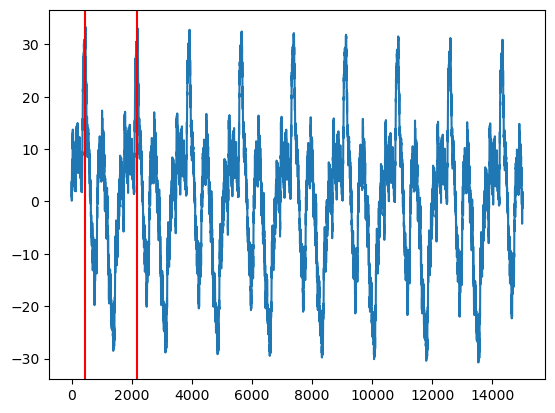

In [341]:
sample_tower = Tower(gas=lr)


heights = sample_tower.rock_shower(15000, return_traj=True)

heights = np.array(heights)

# remove average (fitted) growth to look for pattern
x = np.linspace(0, len(heights), len(heights))
m = (x @ heights) / (x @ x)
fluct = heights - m * x

plt.plot(x, fluct)
plt.axvline(x=453, c='r')
plt.axvline(x=2188, c='r')

Periodic patter, with period $1735$, starting from step $453$.